In [14]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, f_classif
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

In [15]:
np.random.seed(42)

In [16]:
df = pd.read_csv('cleaned_games_dataset.csv', index_col='Unnamed: 0')

In [17]:
df.head()

,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,orb_1_1,...,pts_2_3_opp,home_2_3_opp,betting_line_2_3_opp,off_rating_1_3_opp,off_rating_2_3_opp,over_under_3_opp,game_total_score_3_opp,days_1_back_opp,days_2_back_opp,days_3_back_opp
1,31,78,0.397,7,23,0.304,28,38,0.737,18,...,114,1,9.5,110.75,114.78,195.0,224,2,2,2
2,37,70,0.529,11,27,0.407,18,27,0.667,8,...,87,0,8.0,101.62,95.06,189.5,180,3,1,2
5,31,72,0.431,6,21,0.286,27,33,0.818,13,...,84,0,-3.5,94.13,87.86,188.0,174,1,3,1
6,30,71,0.423,8,21,0.381,34,42,0.810,16,...,102,1,-3.5,101.45,108.92,195.0,197,1,3,1
9,35,79,0.443,7,16,0.438,13,15,0.867,11,...,74,0,8.0,93.25,77.54,188.0,163,2,1,3


In [18]:
df.drop(['gid_today', 'game_total_score'], axis=1, inplace=True)

I split my predicted feature into two sets, one set where I will try to fit a model to accurately predict over bets, and the same set, but with a model that will try to predict under bets.

In [19]:
X = df[[x for x in df.columns if x != 'bet_won_over' and x != 'bet_won_under']]
y_over = df[['bet_won_over', 'game_date']]
y_under = df[['bet_won_under', 'game_date']]

To split my data, I will have the first 4 seasons (2014-2017) be the set data I use to train my models, and the 2018 season be the testing data that I will score my model on.

In [20]:
X_train = X[X['game_date'] < '2017-09-01']
X_test = X[X['game_date'] > '2017-09-01']

y_train_over = y_over[y_over['game_date'] < '2017-09-01']
y_train_under = y_under[y_under['game_date'] < '2017-09-01']
y_test_over = y_over[y_over['game_date'] > '2017-09-01']
y_test_under = y_under[y_under['game_date'] > '2017-09-01']


In [21]:
X_train.drop('game_date', axis=1, inplace=True)
X_test.drop('game_date', axis=1, inplace=True)
y_train_over = y_train_over['bet_won_over']
y_test_over = y_test_over['bet_won_over']
y_train_under = y_train_under['bet_won_under']
y_test_under = y_test_under['bet_won_under']

/Users/jordanbailey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/jordanbailey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Logistic Regression

In [9]:
log_reg_over = LogisticRegressionCV(Cs=[0.1, 0.6], scoring='neg_log_loss')
log_reg_over.fit(X_train, y_train_over)

LogisticRegressionCV(Cs=[0.1, 0.6], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

In [10]:
log_reg_over.score(X_train, y_train_over)

0.5521251850285472

In [11]:
log_reg_over.score(X_test, y_test_over)

0.510575296108291

In [12]:
pred_probas_over = log_reg_over.predict_proba(X_test)

In [13]:
pred_probas_over

array([[0.38513549, 0.61486451],
       [0.38497477, 0.61502523],
       [0.30018209, 0.69981791],
       ...,
       [0.49337795, 0.50662205],
       [0.67240899, 0.32759101],
       [0.67156494, 0.32843506]])

This threshold calculation I making in the next cell will allow to set a level, above which I will term a prediction "confident." I will be using these confident predictions to compile my betting strategy

In [54]:
bet_over  = [x[1] > .64 for x in pred_probas_over]

In [55]:
sum(bet_over)

31

In [56]:
y_test_over[bet_over].mean()

0.5806451612903226

In [57]:
log_reg_under = LogisticRegressionCV(Cs=[0.1, 0.6], scoring='neg_log_loss')
log_reg_under.fit(X_train, y_train_under)

LogisticRegressionCV(Cs=[0.1, 0.6], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

In [58]:
log_reg_under.score(X_train, y_train_under)

0.562698244872066

In [59]:
log_reg_under.score(X_test, y_test_under)

0.5143824027072758

In [60]:
pred_probas_under = log_reg_under.predict_proba(X_test)

In [61]:
bet_under  = [x[1] > .62 for x in pred_probas_under]

In [62]:
sum(bet_under)

63

In [63]:
y_test_under[bet_under].mean()

0.5714285714285714

In [64]:
coefs = pd.DataFrame(log_reg_over.coef_, columns=X_train.columns)

coefs.T.sort_values(0).head().T

,stl_1_3_opp,stl_1_3,ft_2_3,ft_2_3_opp,home_2_2
0,-0.029516,-0.029479,-0.026623,-0.026617,-0.024344


In [65]:
coefs.T.sort_values(0).tail().T

,fta_2_3,home_1_2_opp,home_1_2,tov_1_3,tov_1_3_opp
0,0.019358,0.024572,0.024578,0.025679,0.025681


## Random Forest Classifier

In [98]:
ss = StandardScaler()
rfc = RandomForestClassifier()

In [99]:
pipe_rfc = Pipeline([
    ('ss', ss),
    ('rfc', rfc)
])

In [100]:
params_rfc = {
    'rfc__n_estimators': [10, 50, 100],
    'rfc__max_depth': [3, 6, 10],
    'rfc__min_samples_split': [2, 3, 4]
}

In [101]:
ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

In [72]:
gs_rfc_over = GridSearchCV(pipe_rfc, param_grid=params_rfc, cv=ts_split, scoring='roc_auc')
gs_rfc_over.fit(X_train, y_train_over)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1a0de29518>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rfc__n_estimators': [10, 50, 100], 'rfc__max_depth': [3, 6, 10], 'rfc__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [74]:
gs_rfc_over.score(X_train, y_train_over)

0.7146182134236571

In [75]:
gs_rfc_over.score(X_test, y_test_over)

0.5175117016977135

In [76]:
print(gs_rfc_over.best_score_)
print(gs_rfc_over.best_params_)

0.5118889552361107
{'rfc__max_depth': 6, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 10}


In [77]:
pred_probas_rfc_over = gs_rfc_over.predict_proba(X_test)

In [78]:
pred_probas_rfc_over

array([[0.52266173, 0.47733827],
       [0.47643224, 0.52356776],
       [0.57069955, 0.42930045],
       ...,
       [0.39794281, 0.60205719],
       [0.53872339, 0.46127661],
       [0.56472091, 0.43527909]])

In [94]:
rfc_bet_over  = [x[1] > .56 for x in pred_probas_rfc_over]

In [95]:
sum(rfc_bet_over)

116

In [96]:
y_test_over[rfc_bet_over].mean()

0.4827586206896552

In [102]:
gs_rfc_under = GridSearchCV(pipe_rfc, param_grid=params_rfc, cv=ts_split, scoring='roc_auc')
gs_rfc_under.fit(X_train, y_train_under)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1a2337f5c8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rfc__n_estimators': [10, 50, 100], 'rfc__max_depth': [3, 6, 10], 'rfc__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [103]:
gs_rfc_under.score(X_train, y_train_under)

0.9927407995987374

In [104]:
gs_rfc_under.score(X_test, y_test_under)

0.48739996277684716

In [105]:
print(gs_rfc_under.best_score_)
print(gs_rfc_under.best_params_)

0.5065945002301306
{'rfc__max_depth': 10, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 50}


In [106]:
pred_probas_rfc_under = gs_rfc_under.predict_proba(X_test)

In [119]:
rfc_bet_under = [x[1] > .55 for x in pred_probas_rfc_under]

In [120]:
y_test_under[rfc_bet_under].sum()

74

In [121]:
y_test_under[rfc_bet_under].mean()

0.4539877300613497

## Pipeline to explore feature selection w/ SelectKBest

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectFromModel

In [126]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(k=150)),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_k150 = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_k150.fit(X_train, y_train_over)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x10740c9e8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=150, score_func=<function f_classif at 0x1a0d9ad598>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [127]:
gs_k150.score(X_train, y_train_over)

0.5705806623616203

In [128]:
gs_k150.score(X_test, y_test_over)

0.5195252822595671

In [133]:
best_150_cols = X_train.columns[gs_k150.best_estimator_.named_steps['kbest'].get_support()]

k150_coef = gs_k150.best_estimator_.named_steps['logreg'].coef_

pd.DataFrame(k150_coef, columns=best_150_cols).T.sort_values(0, ascending=False).head()

,0
pts_1_3_opp,0.119819
pts_1_3,0.114728
orb_2_3,0.104816
orb_2_3_opp,0.103506
fta_1_2,0.070778


In [134]:
pred_probas_over_k150 = gs_k150.predict_proba(X_test)

In [135]:
k150_bets_over = [x[1]>.6 for x in pred_probas_over_k150]

In [136]:
y_test_over[k150_bets_over].sum()

39

In [137]:
y_test_over[k150_bets_over].mean()

0.582089552238806

In [138]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(k=150)),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

In [139]:
gs_k150_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_k150_under.fit(X_train, y_train_under)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x10740dca8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=150, score_func=<function f_classif at 0x1a0d9ad598>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [140]:
gs_k150_under.score(X_train, y_train_under)

0.571588668624563

In [141]:
gs_k150_under.score(X_test, y_test_under)

0.5301521854285673

In [142]:
pred_probas_under_k150 = gs_k150_under.predict_proba(X_test)

In [158]:
k150_bets_under = [x[1] > .62 for x in pred_probas_under_k150]

In [159]:
y_test_under[k150_bets_under].sum()

32

In [160]:
y_test_under[k150_bets_under].mean()

0.64

## PCA

In [161]:
ss = StandardScaler()

In [162]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [163]:
pca = PCA(n_components=100)

In [164]:
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

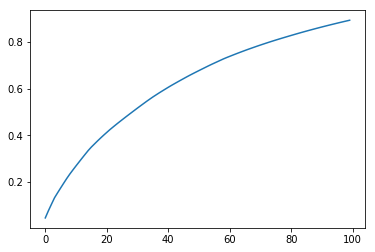

In [165]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [166]:
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_pca_over = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_pca_over.fit(X_train_pca, y_train_over)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x107402f68>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [167]:
gs_pca_over.score(X_train_pca, y_train_over)

0.5569705159793086

In [168]:
gs_pca_over.score(X_test_pca, y_test_over)

0.5045366471662257

In [170]:
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_pca_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_pca_under.fit(X_train_pca, y_train_under)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x10740c468>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [171]:
gs_pca_under.score(X_train_pca, y_train_under)

0.5559528072819718

In [172]:
gs_pca_under.score(X_test_pca, y_test_under)

0.5084446448768056

## SelectFromModel

In [23]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('frommodel', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_from_model = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_from_model.fit(X_train, y_train_over)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1a1332e780>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('frommodel', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [24]:
gs_from_model.score(X_train, y_train_over)

0.5843167751874735

In [25]:
gs_from_model.score(X_test, y_test_over)

0.5219680922721501

### We set `fm_bet_over` to 1 for all locations where the model confidently (>.6) predicts an over will win


In [26]:
pred_probas_over_fm = gs_from_model.predict_proba(X_test)
fm_bet_over = [x[1] > .6 for x in pred_probas_over_fm]

In [27]:
y_test_over[fm_bet_over].sum()

62

In [28]:
y_test_over[fm_bet_over].mean()

0.543859649122807

In [29]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('frommodel', SelectFromModel(LogisticRegression(penalty='l1'))),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {'logreg__C': [1, .5, .1]}

ts_split = TimeSeriesSplit(n_splits=3).split(X_train)

gs_from_model_under = GridSearchCV(pipe ,params, scoring='roc_auc', cv = ts_split)

gs_from_model_under.fit(X_train, y_train_under)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x10d8fbf10>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('frommodel', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [1, 0.5, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [30]:
gs_from_model_under.score(X_train, y_train_under)

0.5838575249438587

In [31]:
gs_from_model_under.score(X_test, y_test_under)

0.5299503214076079

### We set `fm_bet_under` to 1 for all locations where the model confidently (>.6) predicts an under will win

In [32]:
pred_probas_under_fm = gs_from_model_under.predict_proba(X_test)
fm_bet_under = [x[1] > .6 for x in pred_probas_under_fm]

In [33]:
y_test_under[fm_bet_under].mean()

0.5520833333333334

In [34]:
under_thresh_dict = {}
under_winnings_dict = {}

for thresh in np.linspace(.5, .66, 16):
    under_thresh_dict[thresh] = sum([x[1] > thresh for x in pred_probas_under_fm])
    under_winnings_dict[thresh] = np.mean(y_test_under[[x[1] > thresh for x in pred_probas_under_fm]])


On the below graph, the red line represents the amount of games with a confidently predicted under bet, graphed over a range of thresholds for what I'm considering confident. The blue line show the mean of the # of bets won given a certain threshold of confidence.

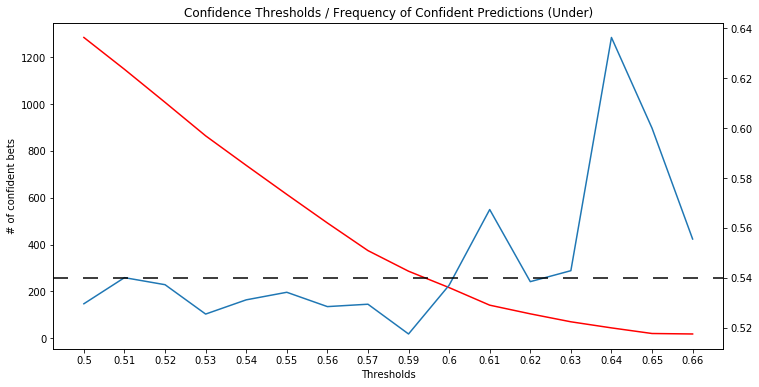

In [35]:
rounded_labels_under = [round(x, 2) for x in under_thresh_dict.keys()]

dashes = [10, 10]

plt.figure(figsize=(12,6))
plt.plot(under_thresh_dict.values(), c='r')
plt.xticks(np.arange(16), rounded_labels_under)
plt.title('Confidence Thresholds / Frequency of Confident Predictions (Under)')
plt.xlabel('Thresholds')
plt.ylabel('# of confident bets')
ax2 = plt.twinx()
ax2.plot(under_winnings_dict.values())
ax2.axhline(0.54, dashes=dashes, c='black');

In [36]:
y_test_under[fm_bet_under].sum()

106

In [37]:
y_test_under[fm_bet_under].mean()

0.5520833333333334

In [38]:
over_thresh_dict = {}
over_winnings_dict = {}

for thresh in np.linspace(.5, .66, 16):
    over_thresh_dict[thresh] = sum([x[1] > thresh for x in pred_probas_over_fm])
    over_winnings_dict[thresh] = np.mean(y_test_over[[x[1] > thresh for x in pred_probas_over_fm]])


On the below graph, the red line represents the amount of games with a confidently predicted over bet, graphed over a range of thresholds for what I'm considering confident. The blue line show the mean of the # of bets won given a certain threshold of confidence.

In [39]:
rounded_labels_over = [round(x, 2) for x in over_thresh_dict.keys()]

No handles with labels found to put in legend.


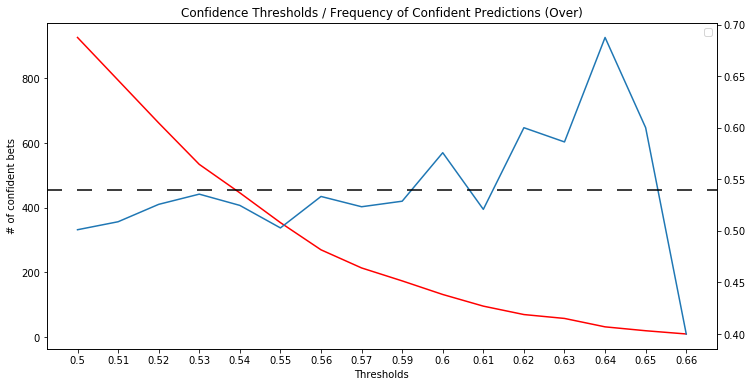

In [62]:
rounded_labels_over = [round(x, 2) for x in over_thresh_dict.keys()]

dashes = [10, 10]

plt.figure(figsize=(12,6))
plt.plot(over_thresh_dict.values(), c='r')
plt.xticks(np.arange(16), rounded_labels_over)
plt.title('Confidence Thresholds / Frequency of Confident Predictions (Over)')
plt.xlabel('Thresholds')
plt.ylabel('# of confident bets')
ax2 = plt.twinx()
ax2.plot(over_winnings_dict.values())
ax2.axhline(0.54, dashes=dashes, c='black');

Below is a plot comparing the mean % of confident predictions for both under bets and over bets. Blue is for over bets, and orange is for under bets.

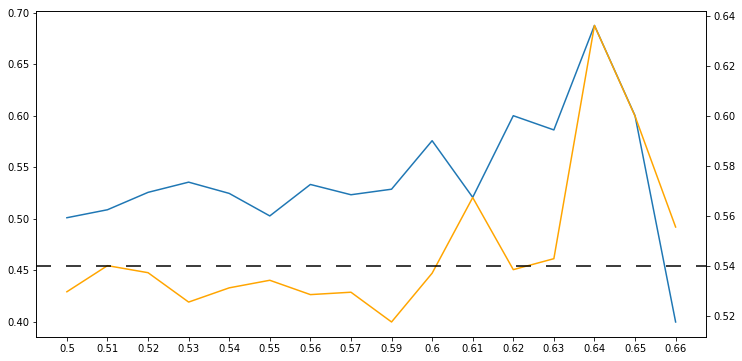

In [41]:
plt.figure(figsize=(12,6))
plt.plot(over_winnings_dict.values())
plt.xticks(np.arange(16), rounded_labels_over)
ax2 = plt.twinx()
ax2.plot(under_winnings_dict.values(), c='orange')
ax2.axhline(0.54, dashes=dashes, c='black');

In [42]:
selectfromcols = X_train.columns[gs_from_model_under.best_estimator_.named_steps['frommodel'].get_support()]

selectfrom_coef = gs_from_model_under.best_estimator_.named_steps['logreg'].coef_

pd.DataFrame(selectfrom_coef, columns=selectfromcols).T.sort_values(0, ascending=False).head(10)

,0
ft_1_3_opp,0.191877
ft_1_3,0.191876
fga_1_1,0.187465
fga_1_1_opp,0.187463
fg%_1_1_opp,0.169259
fg%_1_1,0.169256
off_rating_2_1,0.157706
off_rating_2_1_opp,0.157693
fg%_2_2_opp,0.156538
fg%_2_2,0.156536


In [43]:
pd.DataFrame(selectfrom_coef, columns=selectfromcols).T.sort_values(0, ascending=False).tail(10)

,0
fg_1_1_opp,-0.131057
fg_1_1,-0.131058
fta_2_3,-0.155139
fta_2_3_opp,-0.155144
game_total_score_1,-0.159003
game_total_score_1_opp,-0.159004
pts_2_1_opp,-0.178306
pts_2_1,-0.178308
fta_1_3_opp,-0.219723
fta_1_3,-0.219723


In [44]:
len(selectfromcols)

226

My final model has 228 features

### Modeling Conclusions

In [45]:
sum(fm_bet_under)

192

In [46]:
sum(fm_bet_over)

114

In [47]:
fm_confident_under = y_test_under[fm_bet_under]

In [48]:
fm_confident_over = y_test_over[fm_bet_over]

In [49]:
fm_confident_over = fm_confident_over.rename('bet_won_over_pred')

In [50]:
fm_confident_under = fm_confident_under.rename('bet_won_under_pred')

In [51]:
games_to_bet = pd.concat([y_test_over, y_test_under], axis=1)

In [52]:
games_to_bet['bet_over'] = list(map(int, fm_bet_over))
games_to_bet['bet_under'] = list(map(int, fm_bet_under))

In [53]:
games_to_bet['bet_either'] = list((games_to_bet['bet_over']==1) | (games_to_bet['bet_under']==1))

In [54]:
games_to_bet.drop(labels=[x for x in games_to_bet.index if x%2], inplace=True)

In [55]:
games_to_bet.head()

,bet_won_over,bet_won_under,bet_over,bet_under,bet_either
1262,0,1,1,0,True
1266,0,1,1,0,True
1270,0,1,0,0,False
1274,1,0,0,0,False
1278,1,0,0,0,False


In [56]:
bets = games_to_bet[games_to_bet['bet_either'] == 1].copy()

In [57]:
bets.drop('bet_either', 1, inplace=True)

In [58]:
betting_sets = bets.to_records(index=False)

### Simulation

Below is a simulation I created to test how well someone could do if they bet a fixed amount of money (200 dollars) on every game where I predicted a "confident" outcome. These bets return 190 if they hit (bookkeapers typically return 100 dollars for a bet of 105). So, for every game with a confident prediction, you win 190 dollars for a correct prediction, and lose 200 dollars for an incorrect prediction.

In [59]:
pot = 10000
running_total = []
for game in betting_sets:
    if game[2] and game[0]:
        pot += 190
    if game[2] and not game[0]:
        pot -= 200
    if game[3] and game[1]:
        pot += 190
    if game[3] and not game[1]:
        pot -= 200
    if pot <= 0:
        break
    running_total.append(pot)
print(pot)

12160


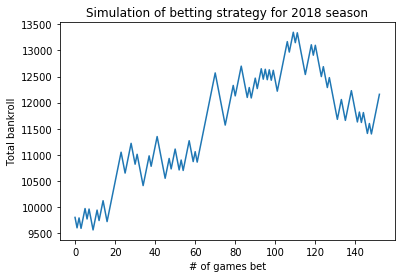

In [60]:
plt.plot(running_total)
plt.title('Simulation of betting strategy for 2018 season')
plt.ylabel('Total bankroll')
plt.xlabel('# of games bet');

In [61]:
games_to_bet[games_to_bet.bet_either == True].describe()

,bet_won_over,bet_won_under,bet_over,bet_under
count,153.000000,153.000000,153.000000,153.000000
mean,0.483660,0.509804,0.372549,0.627451
std,0.501374,0.501546,0.485071,0.485071
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000
